<h1 align="center"> Image Captioning With Attention</h1>

In this notebook you will teach network to use attention during captioning images.

Here is what we need to do:
1. Take pretrained VGG19 to build feature vectors for positions of images.
2. Stack LSTM with attention on top of that.
3. Train the model, draw attention maps.

This assignment is based on the paper "Show, Attend and Tell" (https://arxiv.org/abs/1502.03044).

In [163]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [164]:
import json

In [165]:
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline

In [166]:
from tqdm import tqdm
import h5py

In [167]:
img_path = "/media/ryqc/datasets/img_codes.hdf5"
caption_path = "/media/ryqc/datasets/captions_tokenized.json"

## Data structure (5p)

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained VGG19 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py).

The whole process takes anywhere between a day on CPU and 30min on 1x GeForce GTX 1060. If you want to play with that yourself, [you're welcome](https://drive.google.com/file/d/1NLtoLqZzeES_flgs9kmmeZD_tsCTenH1/view?usp=sharing).

Please either download data from [here](https://drive.google.com/drive/folders/1ZDxySDJJcUbdiHqKxUl5BFERN5Lhf7Lk?usp=sharing) or generate it manually using the above script.

In [168]:
f = h5py.File(img_path, 'r')
img_codes = f['data']


In [169]:
#captions = json.load(open('captions_tokenized.json'))
with open(caption_path, 'r') as f_json:
    captions = json.load(f_json)


In [170]:
print("Each image code is a 512x9x9-unit tensor [ shape: %s x %s ]" % (str(len(img_codes)), str(img_codes[0].shape)))
print(img_codes[0][:3].round(2), end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 512x9x9-unit tensor [ shape: 118287 x (512, 9, 9) ]
[[[0.   0.   0.   0.   0.07 0.69 0.   0.   0.  ]
  [0.   0.24 0.   0.   0.63 1.94 1.21 0.72 0.46]
  [0.77 0.76 0.   0.   0.   0.88 1.65 2.37 1.14]
  [0.21 0.   0.   0.   2.8  3.3  2.93 6.29 3.48]
  [0.   0.   0.   0.   3.29 3.81 2.24 2.76 0.01]
  [0.   0.   0.   1.18 0.32 0.08 0.   0.   0.  ]
  [1.02 1.76 0.89 1.77 0.   0.   0.   0.   0.  ]
  [0.   1.36 0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.09 0.3  0.  ]]

 [[0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.17 0.   0.   0.   0.   0.  ]
  [0.   0.95 0.   0.   0.   0.   0.   0.   0.  ]
  [0.34 1.5  0.   0.   0.36 0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.23 0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.52 0.   0.   0.  ]
  [0.   0.34 0.   0.   0.   0.   0.86 0.34 0.  ]
  [0.   0.47 0.26 0.41 0.   0.   1.08 0.38 0.  ]]

 [[1.09 3.03 2.15 0.65 0.   0.   1.06 0.2

As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [171]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

captions[0][0] # example to see what is going on

['#START#',
 'closeup',
 'of',
 'bins',
 'of',
 'food',
 'that',
 'include',
 'broccoli',
 'and',
 'bread',
 '.',
 '#END#']

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts.

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [172]:
# Build a Vocabulary
from collections import Counter
word_counts: Counter = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
# <YOUR CODE HERE>
for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)
print(word_counts.most_common(10))

[('a', 978125), ('#START#', 591435), ('#END#', 591435), ('.', 444651), ('on', 215537), ('of', 203940), ('the', 197668), ('in', 183933), ('with', 154705), ('and', 140709)]


In [173]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [174]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

# yields a 2D NumPy array where:
# Each row is a caption (as word indices)
# All captions are of equal length (padded with pad_ix)
# Unknown words are replaced with unk_ix

In [175]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   14,  287,  141,   14, 1130,  256,   62,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,  287,   62,   14, 1130,  256,  141,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,   90,  141,   14, 1291,   62,   44,    5,   14, 1287,
          13,    2,    3],
       [   1,   14, 1238, 1370,   14, 1291,   62,   14,   73,   74,   13,
           2,    3,    3],
       [   1,   14,   90,   18,   71,  342,  141,   14, 1291,   62,   14,
        1287,   13,    2]], dtype=int32)

## Building our neural network (8p)

As we mentioned earlier, we shall build an rnn "language-model" conditioned on the features from the convolutional part.

We'll unbox the inception net later to save memory, for now just pretend that it's available.

In [176]:
import torch, torch.nn as nn
import torch.nn.functional as F
import math

### Attention

There are $K$ objects that you can pay attention to.
Each object is characterized by the key $k_i$ and the value $v_i$.
The attention layer proceeds queries.
For the query $q$, the layer returns a weighted sum of the values of the objects, with weights proportional to the degree of key matching the query:
$$w_i = \frac{\exp(score(q, k_i))}{\sum_{j=1}^K\exp(score(q, k_j))}$$
$$a = \sum_{i=1}^K w_i v_i$$

Here we use $score(q, k) = \frac{q^Tk}{\sqrt{dim(k)}}$, where $dim(k)$ is the dimensionality of the key (which also equals the dimensionality of the query).
For more information see the paper Vaswani et al. "Attention Is All You Need", 2017.

_Hint:_ It is recommended to pay attention to the function torch.bmm, it may be useful below.

#### Score function layer

In [177]:
class ScaledDotProductScore(nn.Module):
    """
    Vaswani et al. "Attention Is All You Need", 2017.
    """
    def __init__(self):
        super().__init__()


    def forward(self, queries, keys):
        """
        queries:  [batch_size x num_queries x dim]
        keys:     [batch_size x num_objects x dim]
        Returns a tensor of scores with shape [batch_size x num_queries x num_objects].
        """
        dim = queries.size(-1)
        scores = torch.bmm(queries, keys.transpose(1,2))
        scores = scores / math.sqrt(dim)
        # <YOUR CODE HERE>
        return scores

Test for ScaledDotProductScore

In [178]:
q = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0],
]], dtype=torch.float32)
o = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
]], dtype=torch.float32)
print(ScaledDotProductScore()(q, o))
print(ScaledDotProductScore()(q, o).shape)

tensor([[[0.4472, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4472, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])
torch.Size([1, 3, 4])


#### Attention layer

In [179]:
class Attention(nn.Module):
    def __init__(self, scorer):
        super().__init__()
        self.scorer = scorer

    def forward(self, queries, keys, values):
        """
        queries:         [batch_size x num_queries x query_feature_dim]
        keys:            [batch_size x num_objects x key_feature_dim]
        values:          [batch_size x num_objects x obj_feature_dim]
        Returns matrix of responses for queries with shape [batch_size x num_queries x obj_feature_dim].
        Saves detached weights as self.attention_map.
        """
        scores = self.scorer(queries, keys) # [B x Q x K]
        # <YOUR CODE HERE>
        weights = F.softmax(scores, dim=-1) # [B x Q x K]
        self.attention_map = weights.detach()
        result = torch.bmm(weights, values) # [B x Q x D_v]
        # <YOUR CODE HERE>
        return result

Tests for Attention layer

In [180]:
scorer = ScaledDotProductScore()
attn = Attention(scorer)

In [181]:
q = torch.randn(2, 3, 5)
k = torch.randn(2, 4, 5)
v = torch.randn(2, 4, 7)
print(attn(q, k, v))
assert attn(q, k, v).shape == (2, 3, 7)

tensor([[[-1.5697, -0.8482,  0.1601, -0.4489, -0.9043,  0.4922,  0.5732],
         [-0.9501, -0.8364, -0.2226, -0.3163, -0.9000, -0.2780,  0.8948],
         [-0.9982, -0.9785, -0.1207, -0.2482, -0.9575, -0.0185,  0.6262]],

        [[ 0.7085,  0.5245,  0.6912,  0.9020, -0.1911, -0.8273,  0.0299],
         [ 0.1387,  0.5825,  1.2066,  0.2786, -0.4172, -0.0196,  0.1337],
         [ 0.3619, -0.2375,  0.7301,  0.0522,  0.3708, -0.3622, -0.5422]]])


In [182]:
q = torch.tensor([[
    [0.01],
    [1],
    [100],
]], dtype=torch.float32)
o = torch.tensor([[
    [-1],
    [0],
    [1],
]], dtype=torch.float32) * 1000
a = attn(q, o, o)
assert torch.isnan(attn.attention_map).sum() == 0
assert torch.isnan(a).sum() == 0

In [183]:
q = torch.tensor([[
    [0, 1],
    [1, 0],
]], dtype=torch.float32)
k = torch.tensor([[
    [0, 0],
    [0, 1],
    [1, 0],
]], dtype=torch.float32)
v = torch.tensor([[
    [0],
    [1],
    [2],
]], dtype=torch.float32)
a = attn(q, k, v)
print('Attention map:\n', attn.attention_map)
print('Responses:\n', a)

Attention map:
 tensor([[[0.2483, 0.5035, 0.2483],
         [0.2483, 0.2483, 0.5035]]])
Responses:
 tensor([[[1.0000],
         [1.2552]]])


### Language model

In [184]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_channels=512):
        """ A recurrent 'head' network for image captioning. Read scheme below. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_channels, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_channels, lstm_units)
        #The initial hidden state (h0) and The initial cell state (c0) of the LSTM.

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) # <YOUR CODE>

        # attention: create attention over image spatial positions
        # The query is previous lstm hidden state, the keys are transformed cnn features,
        # the values are cnn features
        self.attention = Attention(scorer)# <YOUR CODE>

        # attention: create transform from cnn features to the keys
        # Hint: one linear layer shoud work
        # Hint: the dimensionality of keys should be lstm_units as lstm
        # hidden state is the attention query
        self.cnn_to_attn_key = nn.Linear(cnn_channels, lstm_units)# This projects the CNN features into the key space, so they match the dimensionality of the query (hidden state of LSTM).

        # lstm: create a recurrent core of your network. Use LSTMCell
        self.lstm = nn.LSTMCell(emb_size + cnn_channels, lstm_units) # <YOUR CODE>

        # create logits: MLP that takes attention response, lstm hidden state
        # and the previous word embedding as an input and computes one number per token
        # Hint: I used an architecture with one hidden layer, but you may try deeper ones
        self.logits_mlp = nn.Sequential(
            nn.Linear(cnn_channels+ lstm_units + emb_size , cnn_channels),
            nn.ReLU(),
            nn.Linear(cnn_channels, n_tokens)
        )# <YOUR CODE>

    def forward(self, image_features, captions_ix):
        """
        Apply the network in training mode.
        :param image_features: torch tensor containing VGG features for each position.
                               shape: [batch, cnn_channels, width * height]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_features.mean(2))
        initial_hid = self.cnn_to_h0(image_features.mean(2)) #Average the CNN features across spatial dimensions to get a global image summary, then convert to LSTM’s initial state.

        image_features = image_features.transpose(1, 2)# change shape from [B, C, HxW] → [B, HxW, C] so that attention can operate over spatial positions.

        captions_emb = self.emb(captions_ix)  # [B, T, emb_size]
        keys = self.cnn_to_attn_key(image_features)  # [B, HxW, lstm_units] Transform CNN features into keys for attention (so they’re compatible with LSTM hidden state queries).

        h, c = initial_hid, initial_cell
        lstm_out = []
        attention_weights = []

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. In the recurrent loop over tokens:
        #   2.1. transform image vectors to the keys for attention
        #   2.2. use previous lstm state as an attention query and image vectors as values
        #   2.3. apply attention to obtain context vector
        #   2.4. store attention map
        #   2.5. feed lstm with current token embedding concatenated with context vector
        #   2.6. update lstm hidden and cell vectors
        #   2.7. store current lstm hidden state, attention response, and the previous word embedding
        # reccurent_out should be lstm hidden state sequence
        # of shape [batch, caption_length, lstm_units + cnn_channels + emb_size]
        # attention_map should be attention maps sequence
        # of shape [batch, caption_length, width * height]
        for t in range(captions_emb.shape[1]):
            word_emb = captions_emb[:, t, :]  # [B, emb_size]
            queries = h.unsqueeze(1)  # [B, 1, lstm_units]Get the embedding of the current word.Turn LSTM hidden state into a query for attention.

            context = self.attention(queries, keys, image_features)  # [B, 1, cnn_channels]
            context = context.squeeze(1)  # [B, cnn_channels]
            attention_weights.append(self.attention.attention_map.squeeze(1))  # [B, HxW]

            lstm_input = torch.cat([word_emb, context], dim=-1)  # [B, emb+cnn]
            h, c = self.lstm(lstm_input, (h, c))  # h: [B, lstm_units]

            lstm_out.append(torch.cat([h, context, word_emb], dim=-1))  # [B, lstm+cnn+emb] we save everything needed to produce logits later.

        recurrent_out = torch.stack(lstm_out, dim=1)  # [B, T, lstm+cnn+emb]
        attention_map = torch.stack(attention_weights, dim=1)  # [B, T, HxW]

        logits = self.logits_mlp(recurrent_out)  # [B, T, n_tokens]

        return logits, attention_map

In [185]:
network = CaptionNet(n_tokens)

In [186]:
dummy_img_vec = torch.randn(len(captions[0]), 512, 81)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits, dummy_attention_map = network.forward(dummy_img_vec, dummy_capt_ix)
dummy_logits, dummy_attention_map = network.forward(dummy_img_vec, dummy_capt_ix)

print('logits shape:', dummy_logits.shape)
print('attention map shape:', dummy_attention_map.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)
assert dummy_attention_map.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], 81)

logits shape: torch.Size([5, 14, 10403])
attention map shape: torch.Size([5, 14, 81])


#### Train loss function

In [187]:
def compute_loss(network, image_features, captions_ix):
    """
    :param image_features: torch tensor containing VGG features. shape: [batch, cnn_channels, width * height]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones plus
              attention regularizer. Scalar float tensor
    """

    if next(network.parameters()).is_cuda:
        image_features, captions_ix = image_features.cuda(), captions_ix.cuda()

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions, attnetion map and gates for captions_ix_next
    logits_for_next, attention_map = network.forward(image_features, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    B, T, V = logits_for_next.shape
    logits_flat = logits_for_next.view(B * T, V)
    targets_flat = captions_ix_next.view(B * T)

    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=pad_ix)# <YOUR CODE>

    # the regularizer for attention - this one requires the attention over each position to sum up to 1,
    # i. e. to look at the whole image during sentence generation process
    mask = (captions_ix_inp != pad_ix) #B, T]
    masked_attention_map = attention_map * mask[:, :, None].float() #[B, T, 81]
    regularizer = ((1 - masked_attention_map.sum(1)) ** 2).mean() #B, 81]

    return loss + regularizer

In [188]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.detach().cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

#### Optimizer
Create ~~adam~~ your favorite optimizer for the network.

In [189]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

# Training (7p)

* First make train/val split without extra memory usage
* Implement the batch generator
* Than train the network as usual

In [190]:
from torch.utils.data import Dataset

class IdxDataset(Dataset):
    def __init__(self, dataset, idx):
        self.dataset = dataset
        self.idx = idx

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        return self.dataset[self.idx[idx]]

In [191]:
# captions = np.array(captions) # we dont need this since our captions can have a different number of tokens, so np.array() needs idk something uniform i guess

np.random.seed(42)
perm = np.random.permutation(len(img_codes))
threshold = round(len(img_codes) * 0.1)
train_img_idx, val_img_idx = perm[threshold:], perm[: threshold]

train_img_idx.sort()
val_img_idx.sort()
train_img_codes = IdxDataset(img_codes, train_img_idx)
val_img_codes = IdxDataset(img_codes, val_img_idx)
train_captions = IdxDataset(captions, train_img_idx)
val_captions = IdxDataset(captions, val_img_idx)

In [192]:
from random import choice

last_batch_end = {}

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample sequential numbers for image/caption indicies (for trainign speed up)
    global last_batch_end
    random_image_ix = np.arange(batch_size, dtype='int') + last_batch_end.get(len(img_codes), 0)
    last_batch_end[len(img_codes)] = last_batch_end.get(len(img_codes), 0) + batch_size
    if last_batch_end[len(img_codes)] + batch_size >= len(img_codes):
        last_batch_end[len(img_codes)] = 0

    #get images
    batch_images = np.vstack([img_codes[i][None] for i in random_image_ix])
    batch_images = batch_images.reshape(batch_images.shape[0], batch_images.shape[1], -1)

    #5-7 captions for each image
    #captions_for_batch_images = captions[random_image_ix] # Python lists don’t support NumPy array indexing directly.
    captions_for_batch_images = [captions[i] for i in random_image_ix]



    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [193]:
generate_batch(img_codes, captions, 3)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0941, 0.2962, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0764, 0.3785, 0.0000],
          [1.0881, 3.0323, 2.1466,  ..., 0.9595, 1.1179, 0.9478],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0711,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.1465, 1.6479, 1.6033]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3930, 0.9311],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)


* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=3.5~3.7

In [194]:
batch_size = 64  # adjust me
n_epochs = 20    # adjust me
n_batches_per_epoch = 8 # adjust me
n_validation_batches = 2  # how many batches are used for validation after each epoch

In [195]:
from tqdm import tqdm

for epoch in range(n_epochs):
    if torch.cuda.is_available():
        network = network.cuda()

    train_loss=0
    network.train(True)
    with tqdm(range(n_batches_per_epoch)) as iterator:
        for _ in iterator:
            loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

            train_loss += float(loss_t)
    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += float(loss_t)
    val_loss /= n_validation_batches

    if torch.cuda.is_available():
        network = network.cpu()

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss), flush=True)

print("Finished!")

100%|██████████| 8/8 [00:00<00:00, 30.82it/s]



Epoch: 0, train loss: 8.449187755584717, val loss: 7.219236850738525


100%|██████████| 8/8 [00:00<00:00, 27.65it/s]



Epoch: 1, train loss: 6.737296462059021, val loss: 6.511956453323364


100%|██████████| 8/8 [00:00<00:00, 30.04it/s]


Epoch: 2, train loss: 6.154724538326263, val loss: 5.9427618980407715



100%|██████████| 8/8 [00:00<00:00, 31.31it/s]


Epoch: 3, train loss: 5.766883015632629, val loss: 5.68209171295166



100%|██████████| 8/8 [00:00<00:00, 29.96it/s]


Epoch: 4, train loss: 5.546734154224396, val loss: 5.401990175247192



100%|██████████| 8/8 [00:00<00:00, 26.12it/s]



Epoch: 5, train loss: 5.422895729541779, val loss: 5.37009859085083


100%|██████████| 8/8 [00:00<00:00, 30.69it/s]


Epoch: 6, train loss: 5.293955206871033, val loss: 5.188124895095825



100%|██████████| 8/8 [00:00<00:00, 30.15it/s]


Epoch: 7, train loss: 5.163857042789459, val loss: 4.970015287399292



100%|██████████| 8/8 [00:00<00:00, 31.05it/s]



Epoch: 8, train loss: 5.034664630889893, val loss: 5.12660813331604


100%|██████████| 8/8 [00:00<00:00, 29.82it/s]



Epoch: 9, train loss: 4.979247152805328, val loss: 5.003592491149902


100%|██████████| 8/8 [00:00<00:00, 27.68it/s]



Epoch: 10, train loss: 5.029067873954773, val loss: 4.908146858215332


100%|██████████| 8/8 [00:00<00:00, 28.16it/s]


Epoch: 11, train loss: 4.961045563220978, val loss: 4.818296909332275



100%|██████████| 8/8 [00:00<00:00, 29.93it/s]


Epoch: 12, train loss: 4.7928988337516785, val loss: 4.750302791595459



100%|██████████| 8/8 [00:00<00:00, 31.24it/s]


Epoch: 13, train loss: 4.770879685878754, val loss: 4.838902235031128



100%|██████████| 8/8 [00:00<00:00, 21.94it/s]


Epoch: 14, train loss: 4.830101370811462, val loss: 4.67801833152771



100%|██████████| 8/8 [00:00<00:00, 30.18it/s]



Epoch: 15, train loss: 4.68399703502655, val loss: 4.865534543991089


100%|██████████| 8/8 [00:00<00:00, 30.13it/s]



Epoch: 16, train loss: 4.588100850582123, val loss: 4.643850564956665


100%|██████████| 8/8 [00:00<00:00, 32.53it/s]


Epoch: 17, train loss: 4.639277994632721, val loss: 4.549159526824951



100%|██████████| 8/8 [00:00<00:00, 23.18it/s]


Epoch: 18, train loss: 4.502209424972534, val loss: 4.667966604232788



100%|██████████| 8/8 [00:00<00:00, 30.13it/s]


Epoch: 19, train loss: 4.467228293418884, val loss: 4.429348707199097
Finished!


### Apply trained model

Let's unpack our pre-trained VGG network and see what our model is capable of.

In [196]:
from torch import nn
import torch.nn.functional as F
from torchvision.models.vgg import VGG, cfgs as VGG_cfgs, make_layers
from warnings import warn
class BeheadedVGG19(VGG):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """

    def forward(self, x):
        x_for_attn = x= self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = x = self.classifier(x)
        return x_for_attn, logits

features_net = BeheadedVGG19(make_layers(VGG_cfgs['E'], batch_norm=False), init_weights=False)

from torch.utils.model_zoo import load_url
features_net_url = 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
features_net.load_state_dict(load_url(features_net_url))

features_net = features_net.train(False)
if torch.cuda.is_available():
    features_net = features_net.cuda()
features_net = nn.DataParallel(features_net)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [197]:
def generate_caption(image, caption_prefix = ("#START#",),
                     t=1, sample=True, max_len=100):

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

    vectors_9x9, logits = features_net(image[None])
    caption_prefix = list(caption_prefix)

    attention_maps = []

    for _ in range(max_len):

        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        input_features = vectors_9x9.view(vectors_9x9.shape[0], vectors_9x9.shape[1], -1)
        if next(network.parameters()).is_cuda:
            input_features, prefix_ix = input_features.cuda(), prefix_ix.cuda()
        else:
            input_features, prefix_ix = input_features.cpu(), prefix_ix.cpu()
        next_word_logits, cur_attention_map = network(input_features, prefix_ix)
        next_word_logits = next_word_logits[0, -1]
        cur_attention_map = cur_attention_map[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().cpu().numpy()
        attention_maps.append(cur_attention_map.detach().cpu())

        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs)
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break

    return caption_prefix, attention_maps

Here is the code which downloads image, prints different generated captions and visualize attention map.

In [198]:
from matplotlib import pyplot as plt
from skimage.transform import resize
from tempfile import mktemp
from os import remove
%matplotlib inline

# get and preprocess image
def obtain_image(filename=None, url=None):
    if (filename is None and url is None) or (filename is not None and url is not None):
        raise ValueError('You shoud specify either filename or url')
    if url is not None:
        tmpfilename = mktemp()
        !wget {url} -O {tmpfilename} -q
        img = plt.imread(tmpfilename)
        remove(tmpfilename)
    else:
        img = plt.imread(filename)
    img = resize(img, (299, 299), mode='wrap', anti_aliasing=True).astype('float32')
    return img

def show_img(img):
    plt.imshow(img)
    plt.axis('off')

def print_possible_captions(img, num_captions=10, temperature=5.):
    for i in range(num_captions):
        print(' '.join(generate_caption(img, t=temperature)[0][1:-1]))

def draw_attention_map(img, caption, attention_map):
    s = 4
    n = len(caption)
    w = 4
    h = n // w + 1
    plt.figure(figsize=(w * s, h * s))
    plt.subplot(h, w, 1)
    plt.imshow(img)
    plt.title('INPUT', fontsize=s * 4)
    plt.axis('off')
    for i, word, attention in zip(range(n), caption, attention_map):
        plt.subplot(h, w, 2 + i)
        attn_map = attention.view(1, 1, 9, 9)
        attn_map = F.interpolate(attn_map, size=(12, 12), mode='nearest')
        attn_map = F.interpolate(attn_map, size=(299, 299), mode='bilinear', align_corners=False)
        attn_map = attn_map[0, 0][:, :, None]
        attn_map = torch.min(attn_map / attn_map.max(), torch.ones_like(attn_map)).numpy()
        plt.imshow(img * attn_map)
        plt.title(word, fontsize=s * 4)
        plt.axis('off')

def process_image(img):
    print_possible_captions(img)
    c, am = generate_caption(img, t=5.)
    draw_attention_map(img, c[1:-1], am)

In [199]:
img = obtain_image(url="https://thecenterformindfuleating.org/resources/Pictures/asian%20man%20eating.jpg")
show_img(img)

UnidentifiedImageError: cannot identify image file '/tmp/tmpy1mfuzmj'

a man with a shirt and a tie
a man sitting at a table with a plate of food
a man in a white shirt and tie with a fork .
a man with a shirt and a tie with a fork on a plate .
a man with a tie and a fork in front of a table .
a man in a red shirt and tie holding a fork .
a man in a white shirt and tie holding a fork .
a man with a tie and a fork in front of a table .
a man with a tie and a fork in front of a table .
a man with a tie and a tie


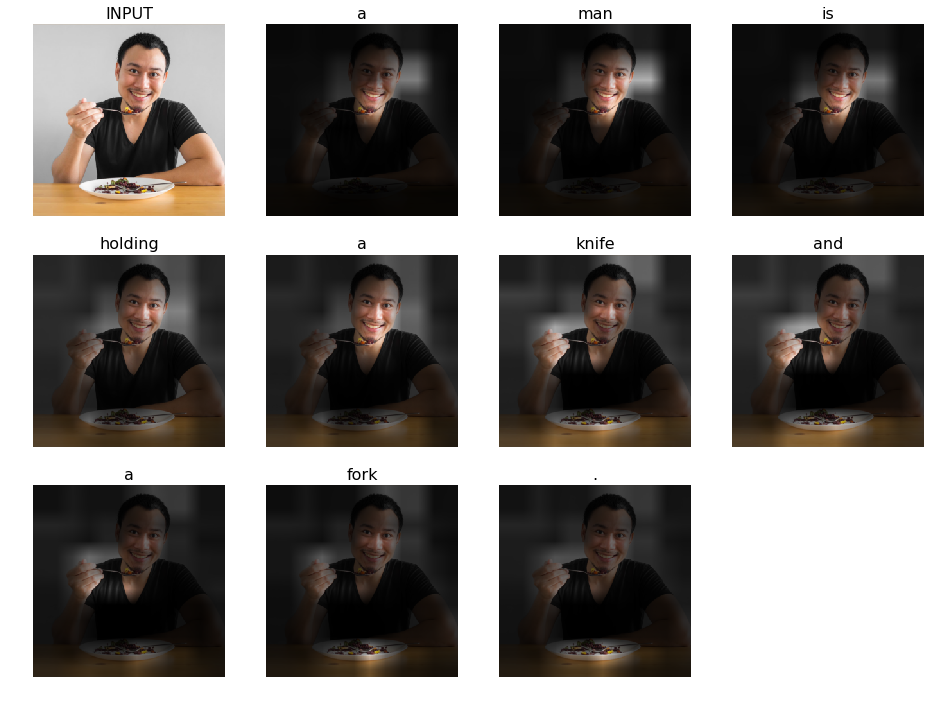

In [ ]:
process_image(img)

a man riding a bike down a road with a man on his bike .
a man riding a bike on a road with a mountain on it
a man riding a bike on a bike path .
a man riding a bike on a road next to a mountain .
a man riding a bike down a road with a dog on the back .
a man riding a bike on a path in the middle of a mountain .
a man riding a bike on a road next to a mountain .
a man riding a bike on a path in the woods .
a person riding a bike on a road with a mountain in the background
a man riding a bike on a bike with a mountain .


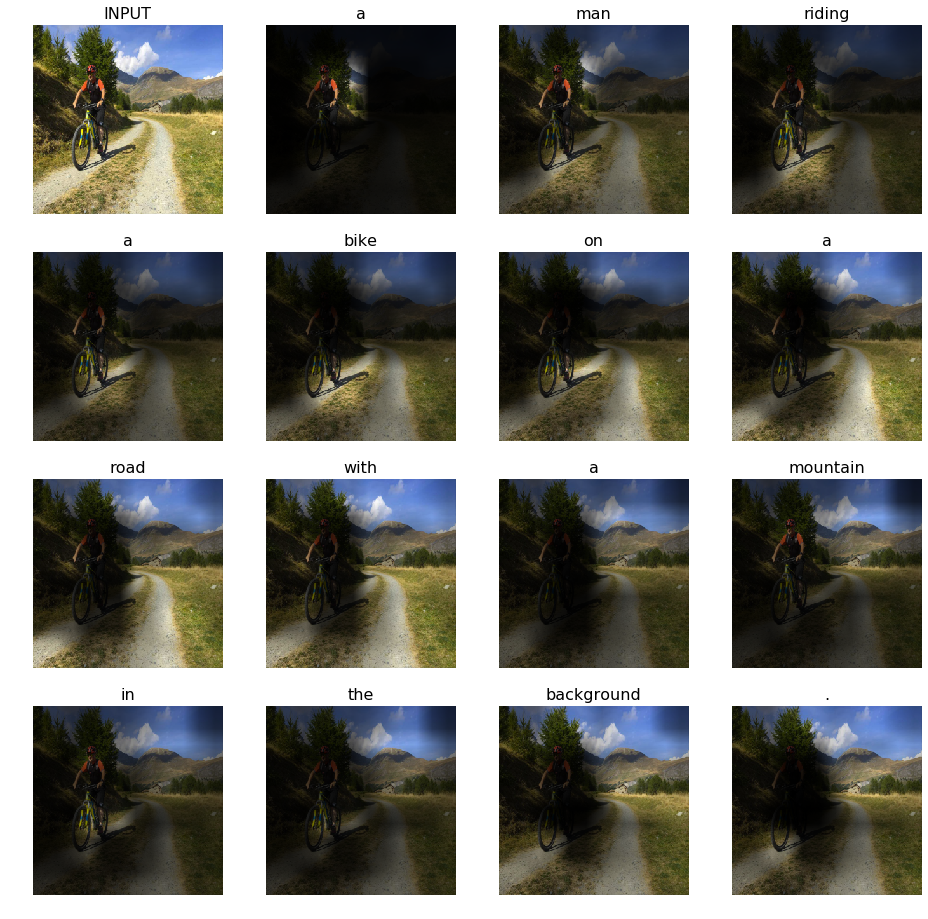

In [ ]:
process_image(obtain_image(url="https://www.dimensioneattiva.it/wp-content/uploads/2016/10/Bike5.jpg"))

a cat that is laying on a couch
a cat that is laying down in the grass .
a cat that is laying down on a couch
a cat that is laying in a chair
a cat that is sitting on a chair
a cat is laying on a couch with a cat .
a cat that is laying down on a chair .
a cat sitting on a couch with a cat in its mouth .
a cat that is laying on a couch
a cat laying on top of a wooden floor .


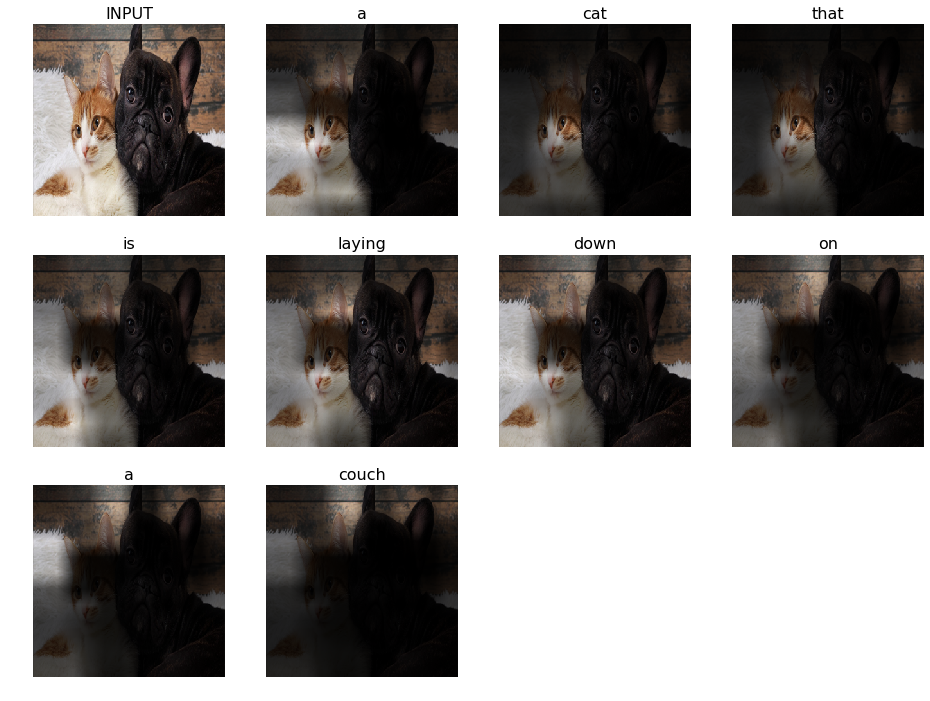

In [ ]:
process_image(obtain_image(url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg"))

a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a skate board .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a skate board .


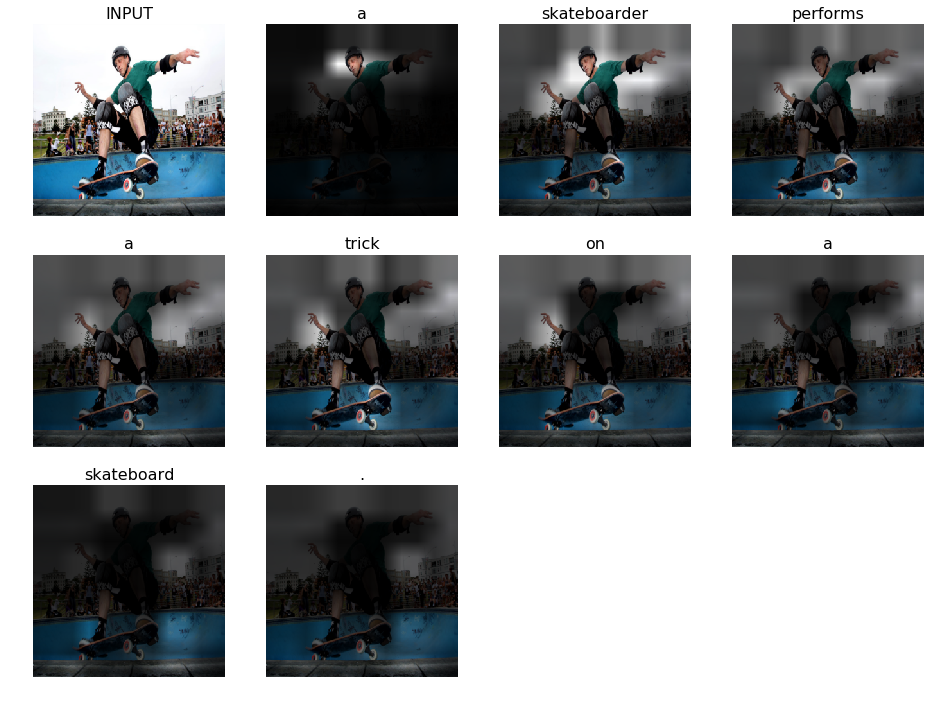

In [ ]:
process_image(obtain_image(url="https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg"))

a bicycle leaning against a tree in the sand .
a bike is sitting on a beach with a surfboard .
a bike leaning against a tree and a tree .
a bike leaning against a tree on a beach .
a bike parked on a beach with a surfboard .
a bike parked on a beach with a surfboard in the background .
a bike parked on a beach with a person on the beach .
a bike is sitting on the beach by a bike .
a bike parked on a beach with a mountain in the background
a bicycle parked on a beach with a surfboard on the beach .


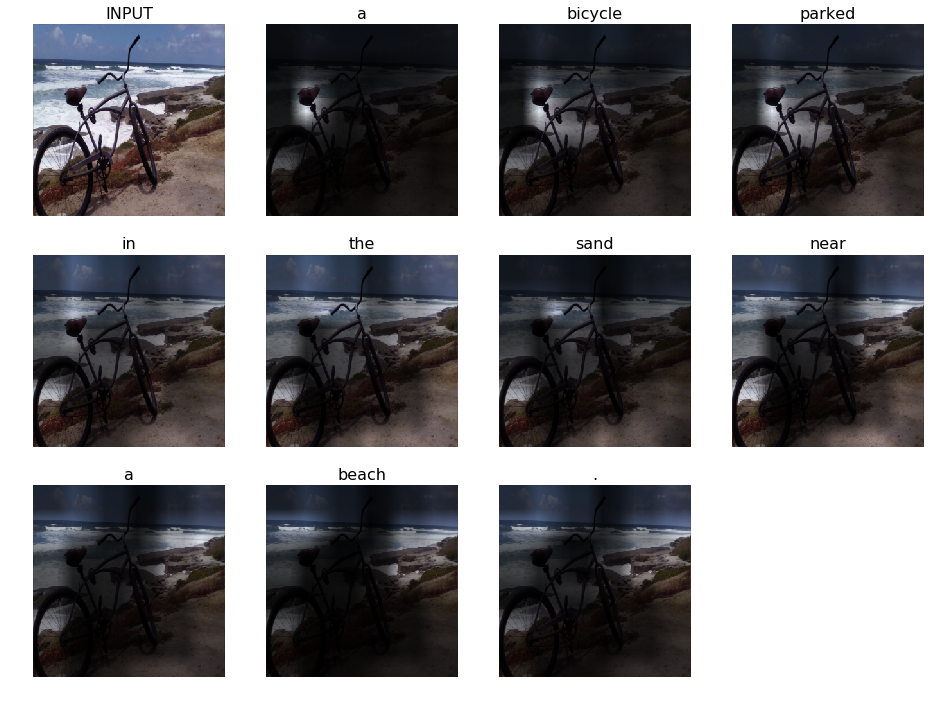

In [ ]:
process_image(obtain_image(filename="/home/oleg/usa00/IMG_20190520_125121.jpg"))

# Demo (10p)
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio
* Describe what you see and draw a conclusion


--- Image 1 ---
a cat is sitting on a cat on a table .
a cat is sitting on a cat on a table .
a cat sitting on a cat is on a table .
a cat sitting on a cat sitting on a table .
a cat sitting on a cat sitting on a table .
a cat is sitting on a table with a table .
a cat sitting on a cat sitting on a table .
a cat sitting on a cat on a table with a cat .
a cat sitting on a cat in a table with a cat .
a cat laying on a cat sitting on a table .


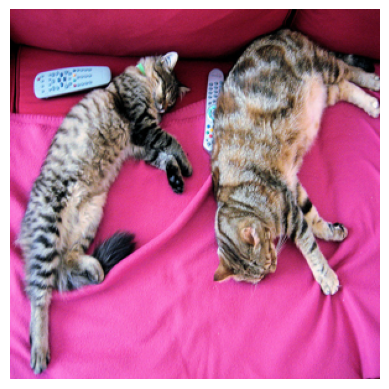

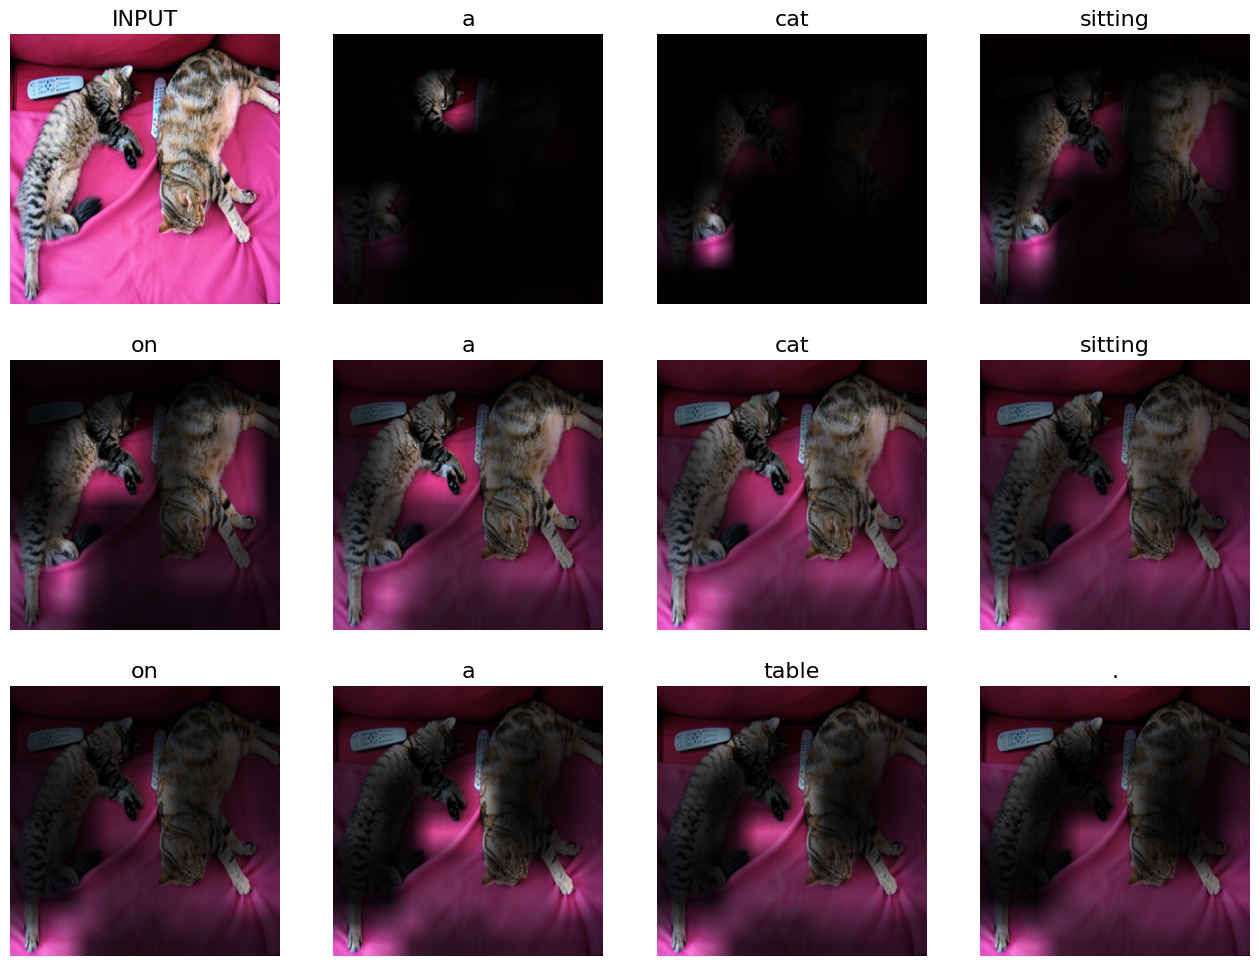

In [150]:
"""import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# 1 real COCO 2017 image URLs
urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg"
    # more images if found haha
]


def get_image(url):
    response = requests.get(url)
    try:
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((299, 299)) # since attention map 9x9
        return np.array(img) / 255.0
    except Exception as e:
        print(f" Could not process image from {url}: {e}")
        return None

imgs = [get_image(url) for url in urls]
imgs = [img for img in imgs if img is not None]


for i, img in enumerate(imgs):
    print(f"\n--- Image {i+1} ---")
    show_img(img)
    process_image(img)


"""
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_folder = 'ComputerVisionCourse/caption_images' 

def get_local_image(filepath):
    try:
        img = Image.open(filepath).convert('RGB')
        img = img.resize((299, 299))
        return np.array(img) / 255.0
    except Exception as e:
        print(f"Could not process {filepath}: {e}")
        return None
    
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpeg')]
image_files.sort()  
image_paths = [os.path.join(image_folder, fname) for fname in image_files]

imgs = [get_local_image(path) for path in image_paths]
imgs = [img for img in imgs if img is not None]

for i, img in enumerate(imgs):
    print(f"\n--- Image {i+1} ---")
    show_img(img)
    process_image(img)


### Conclusion
Here is a place for your conclusions, observations, hypotheses, and any other feedback.

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention over the generated part of the sentense.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt).
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563